#Google Drive Load

In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Parameter Setup

In [28]:
home_folder = '/content/drive/MyDrive/deep learning/final_project/'       #setup directories
slides_directory = home_folder+'slides/'
data_directory = home_folder+'data/'
zoom_level_1=0
zoom_level_2=1                                             
input_size=299                                             #size of the input patches
center_region=128                                          #size of the region of interest
dataset_size_per_slide = 100                               #number of healthy/cancer patches to extract from every input slide
heatmap_slide = ['110']                                    #slide used to generate prediction heatmap
test_slide = ['101','110']                                 #list of slides to be used for testing
training_slides=['075','084','091','096']                  #list of slides to be used for training
reload_patches=False                                        #option to reload patches or use the saved ones
retrain=False                                               #option to retrain the model or use a saved one
data_augmentation=True                                     #option to include data augmentation in training
load_mask_from_disk=True                                  #option to load the saved heatmap mask from disk instead of recalculating it
model_choice = 'convolutional'                             #choose between 'pretrained' and 'convolutional'
file_distinguisher = ''                                    #use to create separate models, results etc (e.g. model2.h5)

if data_augmentation==True:
  parameters='data_aug'
else:
    parameters='no_data_aug'
results_directory = home_folder+'results/'+model_choice+'_'+parameters+'/' 
model_path = results_directory+'model'+ file_distinguisher +'.h5'

#Installs - Imports

In [29]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python
!pip install -U tensorflow-addons
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import keras
import os, random, tqdm, sys
from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Conv2D, BatchNormalization, Activation, AveragePooling2D, concatenate, Flatten, Dense, Dropout
from keras.models import Model, Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from keras.optimizers import RMSprop, Adam
from keras.activations import relu, sigmoid
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from numpy.core.defchararray import add
from IPython.lib import deepreload 

stdout = sys.stdout
sys.stdout = open('junk','w')
deepreload.reload(tqdm)
sys.stdout = stdout

tqdm.__version__

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Requirement already up-to-date: tensorflow-addons in /usr/local/lib/python3.6/dist-packages (0.12.0)


'4.41.1'

#Functions

In [30]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):      
    im_gray = rgb2gray(image)    
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

#Data extract

In [31]:
#Given a slide, its tumor mask and a (x,y) point at level 0, return
#the patches at the required zoom levels, a list of the tissue pixels 
#of lvl1 patch, and a boolean regarding cancerous pixels in the center
def patch(slide, mask, lvl1, lvl2, x, y):
    upper_left_x = int(x-(input_size//2)*slide.level_downsamples[lvl1])
    upper_left_y = int(y-(input_size//2)*slide.level_downsamples[lvl1])
    patch1 = read_slide(slide, upper_left_x, upper_left_y, lvl1, input_size, input_size)  
    mask1 = read_slide(mask, upper_left_x, upper_left_y, lvl1, input_size, input_size)[:,:,0]
    tissue1 = find_tissue_pixels(patch1)
    is_cancerous = np.sum(mask1[int((input_size-center_region)/2):int((input_size-center_region)/2)+center_region, int((input_size-center_region)/2):int((input_size-center_region)/2)+center_region])>0
    upper_left_x = int(x-(input_size//2)*slide.level_downsamples[lvl2])
    upper_left_y = int(y-(input_size//2)*slide.level_downsamples[lvl2])
    patch2 = read_slide(slide, upper_left_x, upper_left_y, lvl2, input_size, input_size)  
    return patch1, patch2, tissue1, is_cancerous

#reads the train and test files and creates a dataset with an equal 
#number of cancer and healthy patches
def collect_data():
   train_files = add(add(home_folder + 'slides/tumor_', list(map(str,training_slides))), '.tif')
   train_mask_files = add(add(home_folder + 'slides/tumor_', list(map(str,training_slides))), '_mask.tif')
   test_file = add(add(home_folder + 'slides/tumor_', list(map(str,test_slide))), '.tif')
   test_mask_file = add(add(home_folder + 'slides/tumor_', list(map(str,test_slide))), '_mask.tif')

   train_input1 = []
   train_input2 = []
   train_output = []
   test_input1 = []
   test_input2 = []
   test_output = []

   for  i in range(len(train_files)):
     cancer_data=0
     healthy_data=0
     slide = open_slide(train_files[i])
     mask_slide = open_slide(train_mask_files[i])
     mask7 = read_slide(mask_slide, 0, 0, 7, mask_slide.level_dimensions[7][0], mask_slide.level_dimensions[7][1])[:,:,0]
     cancers = list(zip(np.nonzero(mask7)[1], np.nonzero(mask7)[0]))
     non_cancers = list(zip(np.where(mask7==0)[1], np.where(mask7==0)[0]))
     while cancer_data<dataset_size_per_slide :
       (can_x, can_y) = random.sample(cancers, 1)[0]       
       cancers.remove((can_x, can_y))
       x = 128*can_x
       y = 128*can_y           
       patch1, patch2, tissue, is_cancerous = patch(slide, mask_slide, zoom_level_1, zoom_level_2, x, y)
       tissue_ratio = len(tissue)/(input_size*input_size)
       if ((tissue_ratio>0.5) & (is_cancerous)):
         train_input1.append(patch1)
         cancer_data+=1
         print('accepted ', cancer_data,' cancer at (',x,',',y,'), ', tissue_ratio, ' tissue, remaining candidates are', len(cancers))
         train_input2.append(patch2)  
         train_output.append(1)      
     while healthy_data<dataset_size_per_slide :
       (can_x, can_y) = random.sample(non_cancers, 1)[0]
       non_cancers.remove((can_x, can_y))
       x = 128*can_x
       y = 128*can_y           
       patch1, patch2, tissue, is_cancerous = patch(slide, mask_slide, zoom_level_1, zoom_level_2, x, y)
       tissue_ratio = len(tissue)/(input_size*input_size)
       if ((tissue_ratio>0.5) & (is_cancerous==False)):
         train_input1.append(patch1)
         healthy_data+=1
         print('accepted ', healthy_data,' healthy_patch at (',x,',',y,'), ', tissue_ratio, ' tissue, remaining candidates are', len(non_cancers))
         train_input2.append(patch2)  
         train_output.append(0)  

   for  i in range(len(test_file)):
     cancer_data=0
     healthy_data=0
     slide = open_slide(test_file[i])
     mask_slide = open_slide(test_mask_file[i])
     mask7 = read_slide(mask_slide, 0, 0, 7, mask_slide.level_dimensions[7][0], mask_slide.level_dimensions[7][1])[:,:,0]
     cancers = list(zip(np.nonzero(mask7)[1], np.nonzero(mask7)[0]))
     non_cancers = list(zip(np.where(mask7==0)[1], np.where(mask7==0)[0]))
     while cancer_data<dataset_size_per_slide :
       (can_x, can_y) = random.sample(cancers, 1)[0]       
       cancers.remove((can_x, can_y))
       x = 128*can_x
       y = 128*can_y           
       patch1, patch2, tissue, is_cancerous = patch(slide, mask_slide, zoom_level_1, zoom_level_2, x, y)
       tissue_ratio = len(tissue)/(input_size*input_size)
       if ((tissue_ratio>0.5) & (is_cancerous)):
         test_input1.append(patch1)
         cancer_data+=1
         print('accepted ', cancer_data,' cancer at (',x,',',y,'), ', tissue_ratio, ' tissue, remaining candidates are', len(cancers))
         test_input2.append(patch2)  
         test_output.append(1)      
     while healthy_data<dataset_size_per_slide :
       (can_x, can_y) = random.sample(non_cancers, 1)[0]
       non_cancers.remove((can_x, can_y))
       x = 128*can_x
       y = 128*can_y           
       patch1, patch2, tissue, is_cancerous = patch(slide, mask_slide, zoom_level_1, zoom_level_2, x, y)
       tissue_ratio = len(tissue)/(input_size*input_size)
       if ((tissue_ratio>0.5) & (is_cancerous==False)):
         test_input1.append(patch1)
         healthy_data+=1
         print('accepted ', healthy_data,' healthy_patch at (',x,',',y,'), ', tissue_ratio, ' tissue, remaining candidates are', len(non_cancers))
         test_input2.append(patch2)  
         test_output.append(0)  

   return train_input1, train_input2, train_output, test_input1, test_input2, test_output


#Collect Data

In [32]:
#Create and save the datasets, or load previously saved ones
train_X1_file = data_directory + 'train_X1.npy'
train_X2_file = data_directory + 'train_X2.npy'
train_Y_file = data_directory + 'train_Y.npy'
test_X1_file = data_directory + 'test_X1.npy'
test_X2_file = data_directory + 'test_X2.npy'
test_Y_file = data_directory + 'test_Y.npy'

if reload_patches== True:
  train_in1, train_in2, train_out, test_in1, test_in2, test_out = collect_data()
  train_X1 = np.asarray(train_in1)
  train_X2 = np.asarray(train_in2)
  train_Y = np.asarray(train_out)
  testX1 = np.asarray(test_in1)
  testX2 = np.asarray(test_in2)
  testY = np.asarray(test_out)
  np.save(train_X1_file, train_X1)
  np.save(train_X2_file, train_X2)
  np.save(train_Y_file, train_Y)
  np.save(test_X1_file, testX1)
  np.save(test_X2_file, testX2)
  np.save(test_Y_file, testY)
else:
  train_X1 = np.load(train_X1_file)
  train_X2 = np.load(train_X2_file)
  train_Y = np.load(train_Y_file)
  testX1 = np.load(test_X1_file)
  testX2 = np.load(test_X2_file)
  testY = np.load(test_Y_file)

trainX1, validateX1, trainY, validateY = train_test_split(train_X1, train_Y, test_size=0.3, random_state=1, stratify=train_Y, shuffle=True)
trainX2, validateX2, trainY, validateY = train_test_split(train_X2, train_Y, test_size=0.3, random_state=1, stratify=train_Y, shuffle=True)

In [33]:
#Create the data generators for train validate and test and define data augmentation features
def generator_two_img(X1, X2, y, batch_size, gen):
    X1=(X1.astype(float))/255.0
    X2=(X2.astype(float))/255.0
    genX1 = gen.flow(X1, y,  batch_size=batch_size, seed=1)
    genX2 = gen.flow(X2, y, batch_size=batch_size, seed=1)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]


aug = ImageDataGenerator(
    rotation_range=180,        
    horizontal_flip=True,
    vertical_flip=True)

aug2 = ImageDataGenerator(
    brightness_range=[0.2,1.0],
    channel_shift_range=0.9,
    rotation_range=180,        
    horizontal_flip=True,
    vertical_flip=True)


dgen = ImageDataGenerator()

if data_augmentation == True:
  train_gen = generator_two_img(trainX1, trainX2, trainY, 32, aug)
else:
  train_gen = generator_two_img(trainX1, trainX2, trainY, 32, dgen)
val_gen = generator_two_img(validateX1, validateX2, validateY, 32, dgen)
test_gen = generator_two_img(testX1, testX2, testY, 32, dgen)

#Model

In [34]:
#Define and compile the model architecture picked in the parameter setup
if model_choice == 'pretrained':
  tower1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(input_size, input_size, 3))
  tower2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(input_size, input_size, 3))
  tower1.trainable = False
  tower2.trainable = False
  myoptimizer = RMSprop(lr=0.0001)     
elif model_choice == 'convolutional'  :
  tower1 = Sequential()
  tower1.add(Conv2D(128, kernel_size=(5, 5), input_shape=(input_size, input_size, 3), padding='same'))
  tower1.add(BatchNormalization())
  tower1.add(Activation('relu'))
  tower1.add(AveragePooling2D(pool_size=(2, 2)))
  tower1.add(Conv2D(64, kernel_size=(5, 5), input_shape=(input_size, input_size, 3), padding='same'))
  tower1.add(BatchNormalization())
  tower1.add(Activation('relu'))
  tower1.add(AveragePooling2D(pool_size=(2, 2)))
  tower1.add(Conv2D(32, kernel_size=(5, 5), input_shape=(input_size, input_size, 3), padding='same'))
  tower1.add(BatchNormalization())
  tower1.add(Activation('relu'))
  tower1.add(AveragePooling2D(pool_size=(2, 2)))   
  
  tower2 = Sequential()
  tower2.add(Conv2D(128, kernel_size=(5, 5), input_shape=(input_size, input_size, 3), padding='same'))
  tower2.add(BatchNormalization())
  tower2.add(Activation('relu'))
  tower2.add(AveragePooling2D(pool_size=(2, 2)))
  tower2.add(Conv2D(64, kernel_size=(5, 5), input_shape=(input_size, input_size, 3), padding='same'))
  tower2.add(BatchNormalization())
  tower2.add(Activation('relu'))
  tower2.add(AveragePooling2D(pool_size=(2, 2)))
  tower2.add(Conv2D(32, kernel_size=(5, 5), input_shape=(input_size, input_size, 3), padding='same'))
  tower2.add(BatchNormalization())
  tower2.add(Activation('relu'))
  tower2.add(AveragePooling2D(pool_size=(2, 2)))    
  myoptimizer = Adam(lr=0.01)


model1_in = tower1.input
model1_out = tower1.output
model2_in = tower2.input
model2_out = tower2.output
for layer in tower2.layers:
  layer._name = layer._name + str("_2") 
conc = concatenate([model1_out, model2_out])
flat = Flatten()(conc)
dense = Dense(192, activation='relu')(flat)
dropout = Dropout(0.3)(dense)
prediction = Dense(1, activation='sigmoid')(dropout)
model = Model([model1_in, model2_in], prediction) 
model.compile(optimizer=myoptimizer, loss='binary_crossentropy', metrics=['accuracy'])

#Train

In [35]:
# early stopping and Progress bar callbacks
early_stopping_call = EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=3, restore_best_weights=True)
tqdm_call= tfa.callbacks.TQDMProgressBar()

#train and save the model
if retrain == True:
  history = model.fit(
    train_gen,
    steps_per_epoch=128,
    epochs=20,
    validation_data=val_gen,
    validation_steps=32,    
    verbose=0,
    callbacks=[tqdm_call, early_stopping_call])   
  model.save(model_path)
else: 
  model = keras.models.load_model(model_path)

In [36]:
#plot train/val accuracy and evaluate the model on the test set
if retrain == True:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig(results_directory+'train_history.png', dpi=100, bbox_inches='tight')
  plt.figure(figsize=(10,10), dpi=100)
  plt.show()

test_loss, test_accuracy = model.evaluate(test_gen, steps=64, callbacks=[tqdm_call])

64/64 [==============================] - 13s 198ms/step - loss: 0.4020 - accuracy: 0.9002



#Output

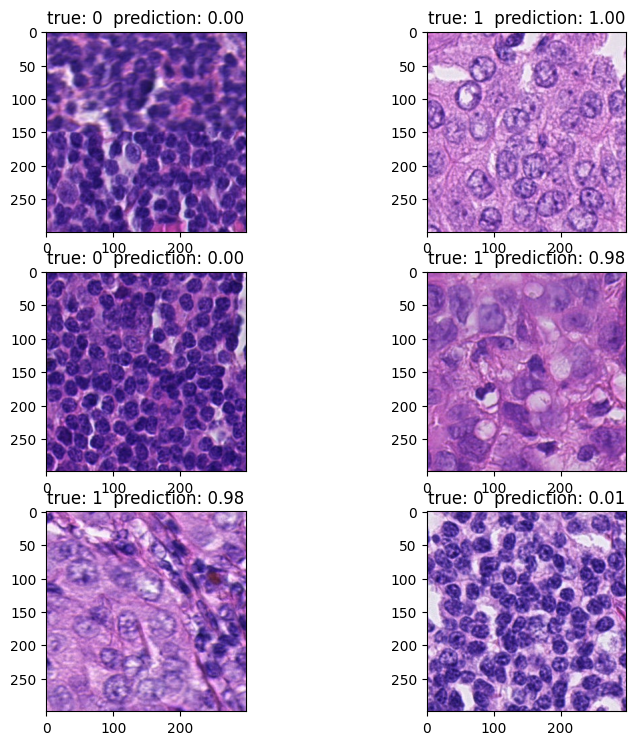

In [37]:
#print some random predictions from the test set
data = next(test_gen)

X = data[0]
Y = data[1]
p = model.predict([X[0], X[1]])

fig = plt.figure(figsize=(9,9), dpi=100)
ax1 = fig.add_subplot(3,2,1)
ax1.title.set_text('true: '+str(Y[0])+'  prediction: '+format(p[0][0], '.2f'))
ax1.imshow(X[0][0])
ax2 = fig.add_subplot(3,2,2)
ax2.title.set_text('true: '+str(Y[1])+'  prediction: '+format(p[1][0], '.2f'))
ax2.imshow(X[0][1])
ax3 = fig.add_subplot(3,2,3)
ax3.title.set_text('true: '+str(Y[2])+'  prediction: '+format(p[2][0], '.2f'))
ax3.imshow(X[0][2])
ax4 = fig.add_subplot(3,2,4)
ax4.title.set_text('true: '+str(Y[3])+'  prediction: '+format(p[3][0], '.2f'))
ax4.imshow(X[0][3])
ax5 = fig.add_subplot(3,2,5)
ax5.title.set_text('true: '+str(Y[4])+'  prediction: '+format(p[4][0], '.2f'))
ax5.imshow(X[0][4])
ax6 = fig.add_subplot(3,2,6)
ax6.title.set_text('true: '+str(Y[5])+'  prediction: '+format(p[5][0], '.2f'))
ax6.imshow(X[0][5])

In [38]:
#create the heatmap data on the file specified in the parameter setup section
def heatmap_data():
   heatmap_file = add(add(slides_directory + 'tumor_', list(map(str,heatmap_slide))), '.tif')
   heatmap_mask_file = add(add(slides_directory + 'tumor_', list(map(str,heatmap_slide))), '_mask.tif')
   test_input1 = []
   test_input2 = []
   predictions = []

   slide = open_slide(heatmap_file[0])
   mask_slide = open_slide(heatmap_mask_file[0])
   image7 = read_slide(slide, 0, 0, 7, slide.level_dimensions[7][0], slide.level_dimensions[7][1])
   patches_to_predict=find_tissue_pixels(image7)
   packed=0
   for i in tqdm.trange(len(patches_to_predict)):
     x=128*patches_to_predict[i][0]
     y=128*patches_to_predict[i][1]       
     patch1, patch2, tissue, is_cancerous = patch(slide, mask_slide, zoom_level_1, zoom_level_2, x, y)
     test_input1.append(patch1)
     test_input2.append(patch2)  
     packed+=1
      
     if (packed==500 or i==len(patches_to_predict)-1):
       X1 = (np.asarray(test_input1).astype(float))/255.0
       X2 = (np.asarray(test_input2).astype(float))/255.0
       my_pred = model.predict([X1, X2])
       del X1, X2
       test_input1 = []
       test_input2 = []
       packed=0
       for k in my_pred:
         predictions.append(k)       
    
   return predictions, patches_to_predict

#print the classification metrics
def print_metrics(true,prediction):
  true_flat=true.flatten()
  pred_flat=prediction.flatten()
  print('Accuracy: %f' % accuracy_score(true_flat, pred_flat))
  print('Precision: %f' % precision_score(true_flat, pred_flat))
  print('Recall: %f' % recall_score(true_flat, pred_flat))
  print('F1 score: %f' % f1_score(true_flat, pred_flat))

In [39]:
#Create and print the heatmaps and the metrics that stem from them
heatmap_file = add(add(slides_directory+'tumor_', list(map(str,heatmap_slide))), '.tif')
heatmap_mask_file = add(add(slides_directory + 'tumor_', list(map(str,heatmap_slide))), '_mask.tif')
slide = open_slide(heatmap_file[0])
tumor_mask = open_slide(heatmap_mask_file[0])
image = read_slide(slide, 0, 0, 7, slide.level_dimensions[7][0], slide.level_dimensions[7][1])
true_mask = read_slide(tumor_mask, 0, 0, 7, tumor_mask.level_dimensions[7][0], tumor_mask.level_dimensions[7][1])[:,:,0]

if (load_mask_from_disk):
  final_mask = np.load(results_directory + str(heatmap_slide[0])+ 'predictions'+file_distinguisher+'.npy')
else:  
  predictions, pos = heatmap_data()
  pred = np.zeros(true_mask.shape)
  final_mask = np.zeros(true_mask.shape)
  for k in range(len(predictions)):
    i=pos[k][0]
    j=pos[k][1]
    pred[i,j]=predictions[k]
  pred=np.transpose(pred)
  for i in range(min(true_mask.shape[0], pred.shape[0])):
    for j in range(min(true_mask.shape[1], pred.shape[1])):
      final_mask[i,j]=pred[i,j]
  np.save(results_directory + str(heatmap_slide[0])+ 'predictions'+file_distinguisher+'.npy', final_mask)  


plt.figure(figsize=(10,10), dpi=100)
plt.title('true')
plt.imshow(image)
plt.imshow(true_mask, cmap='jet', alpha=0.5)

plt.figure(figsize=(10,10), dpi=100)
plt.title('prediction')
plt.imshow(image)
plt.imshow(final_mask, cmap='jet', alpha=0.5)

thresh_mask=np.where(final_mask > 0.9, 1, 0)
plt.figure(figsize=(10,10), dpi=100)
plt.title('prediction_threshold')
plt.imshow(image)
plt.imshow(thresh_mask, cmap='jet', alpha=0.5)

print_metrics(thresh_mask, true_mask)

Output hidden; open in https://colab.research.google.com to view.